# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

<p style="color:#FF333D";><b>Reviewer comments 2</b>:  Please include the HTML report, you can get this by opening File > Download as... > HTML in the Jupyter notebook menu. PS. It's sufficient to only include the Jupyter notebook, HTML report file and the tested images from step 6.</p>
<p style="color:#334DFF";>Dear reviewer, I have published the jupyter notebook and HTML file at the git hub [dog breed](https://github.com/ahiralesc/deep_learning_projects/tree/master/dog_breed) repository. Regarding the images used in step 6. I downloaded them and stored them in the repository img subdirectory. Git hub rejects publishing the original images sizes exceed the file size limit. </p>

In [1]:
import numpy as np
import pandas as pd
import cv2                                     # image processing       
import torch
import torch.nn as nn
import torch.optim as optim                    # optimizer and loss function
import torch.nn.functional as F                # activation functions
import torchvision.models as models            # to load vgg16 model
import torchvision.transforms as transforms
import os                                      # system calls
import matplotlib.pyplot as plt                # plotting
import ast
from tqdm import tqdm                          # show the progress of a loop, i.e tqdm(range(10))
from glob import glob                          # image I/O
from PIL import Image                          # image manipulation
from PIL import ImageFile
from torchvision import datasets

import warnings
warnings.filterwarnings('ignore')


ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline    


# evaluate if cuda is available
cuda_available = torch.cuda.is_available()

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


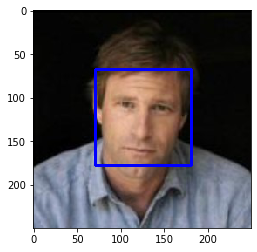

In [37]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [28]:
# returns "True" if face is detected in image stored at img_path
def Haar_detector(img_path):
    # Load the model
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [73]:
# NOTE: Helper function
def detector_frequency(imgset, heuristic=None):
    bset = np.zeros((len(imgset)), dtype=bool)
    for i, fp in enumerate(imgset):
        bset[i] = heuristic(fp)
    return bset

__Answer:__ 
<p style="color:#FF333D";><b>Reviewer comments 1</b>: What percentage of the first 100 images in `human_files` have a detected human face?</p>
<p style="color:#334DFF";>96% </p>
<p style="color:#FF333D";><b>Reviewer comments 1 </b>: What percentage of the first 100 images in `dog_files` have a detected human face?</p>
<p style="color:#334DFF";>18%.<br><br>

**Short summary:** <p style="color:#334DFF";>100 images corresponding to the people and dogs were tested for human face detection. Results show, that 96% and 18% of people and dog images contained a human face. 4% of human faces were not detected and 18% of dogs were incorrectly classified as having a human face. Results migh be explained since Haar classifier use change in contrast values between adjacent rectangular groups of pixels to detect features, such as eyes, mouth, and the edge of the face. However, many of these features are also present in dog and other classes of animal faces.</p>

In [7]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [75]:
#-#-# Do NOT modify the code above this line. #-#-#
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
hset = pd.DataFrame(detector_frequency(human_files_short, heuristic=Haar_detector))
dset = pd.DataFrame(detector_frequency(dog_files_short, heuristic=Haar_detector))

In [76]:
print('Human : ', hset[hset[0]==True].shape[0]/hset.shape[0])
print('Dogs  : ', dset[dset[0]==True].shape[0]/dset.shape[0])

Human :  0.96
Dogs  :  0.18


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [40]:
# define VGG16 model
vgg16 = models.vgg16(pretrained=True)

# check if CUDA is available
if cuda_available:
    vgg16 = vgg16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [3]:
# NOTE: Helper function
def vgg16_labels():
    LABELS_MAP_URL = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt"
    labels = ast.literal_eval(requests.get(LABELS_MAP_URL).text)
    return labels

In [3]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # load the model
    
    # define VGG16 model
    vgg16 = models.vgg16(pretrained=True)
    # check if CUDA is available
    if cuda_available:
        vgg16 = vgg16.cuda()
    
    
    img = Image.open(img_path)   # load the image from persistance
    
    # define image transformations
    transformations = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize( mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
    
    # apply the image transformations
    img = transformations(img).unsqueeze_(0)
    
    # map to gpu
    if cuda_available:
        img = img.cuda()
        
    
    # predict the class for the image
    output = vgg16(img)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    pred = np.squeeze(pred.numpy()) if not cuda_available else np.squeeze(pred.cpu().numpy())
    return int(pred)

In [8]:
# Test code
labels = vgg16_labels()
cid = VGG16_predict(dog_files_short[10])
print(labels[cid])

Afghan hound, Afghan


In [48]:
cid = VGG16_predict(human_files[3])
print(labels[cid])

neck brace


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def VGG16_dog_detector(img_path):
    ## TODO: Complete the function.
    cid = VGG16_predict(img_path)
    if(cid >=151 and cid<=268):
        return True
    return False 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
<p style="color:#FF333D";><b>Reviewer comments 1</b>: What percentage of the images in human_files_short have a detected dog?</p>
<p style="color:#334DFF";>None. </p>
<p style="color:#FF333D";><b>Reviewer comments 1</b>: What percentage of the images in dog_files_short have a detected dog?</p>
<p style="color:#334DFF";>95%.

In [78]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
hset = pd.DataFrame(detector_frequency(human_files_short, heuristic=VGG16_dog_detector))
dset = pd.DataFrame(detector_frequency(dog_files_short  , heuristic=VGG16_dog_detector))

In [79]:
print('Human : ', hset[hset[0]==True].shape[0]/hset.shape[0])
print('Dogs  : ', dset[dset[0]==True].shape[0]/dset.shape[0])

Human :  0.0
Dogs  :  0.95


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

<p style="color:#FF333D";><b>Reviewer comments 2</b>: Write three separate data loaders for the training, validation, and test datasets of dog images. These images should be pre-processed to be of the correct size. The preprocessing code is good, the only problem is that you also applied data augmentation on the validation and test set. The reason we don't want data augmentation for validation and testing is that we want the validation and test sets to represent real images as much as possible. If we augment the images they might not be realistic anymore. For the transformation for the validation and test set it's sufficient to only resize the image to 224x224 pixels.</p>
<p style="color:#334DFF";>Dear reviewer. I appreciate the acute observation. Unconsciously I reused the same data loader for validation and test phases. I have written the two new data loaders, namely: the validation and test loaders. These only apply image resize (224,224) and normalization. I ran new experiments using the transfer learning model that previously achieved test precision of 84%. Follow this [link](#TLRESULTS) for new results.</p>

In [36]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.Resize(size=224),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

data_transform_test = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

data_transform_validate = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

data_dir = 'dogImages/'
batch = 20
workers=0

trainset = datasets.ImageFolder(os.path.join(data_dir, 'train/'), transform=data_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, num_workers=workers, shuffle=True)

testset = datasets.ImageFolder(os.path.join(data_dir, 'test/'), transform=data_transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, num_workers=workers, shuffle=True)

validset = datasets.ImageFolder(os.path.join(data_dir, 'valid/'), transform=data_transform_validate)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch, num_workers=workers, shuffle=True)

loaders_scratch = dict()
loaders_scratch['train'] = trainloader
loaders_scratch['test'] = testloader
loaders_scratch['valid'] = validloader

In [32]:
# Helper function:
def display_workload(loader):
    dataiter = iter(loader)
    imgset, lbset = dataiter.next()
    # imgset = imgset.numpy()
    
    fig = plt.figure(figsize=(25,4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        img = imgset[idx]
        img = (img-torch.min(img))/(torch.max(img)-torch.min(img)) #apply min-max normalization
        img = np.transpose(img,(1, 2, 0))
        plt.imshow(img)

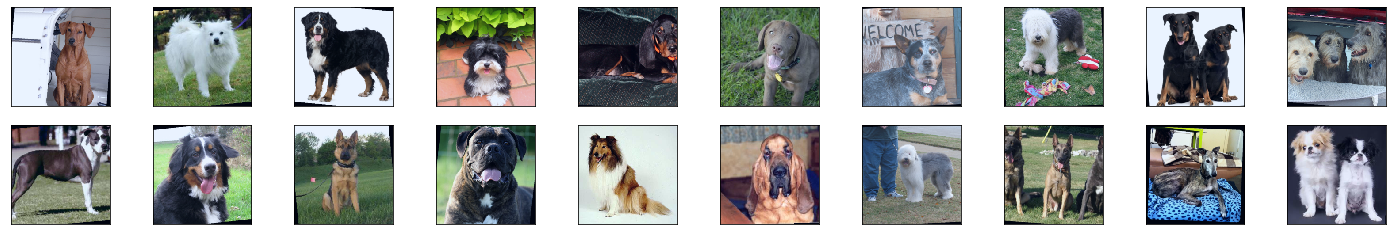

In [11]:
display_workload(loaders_scratch['train'])

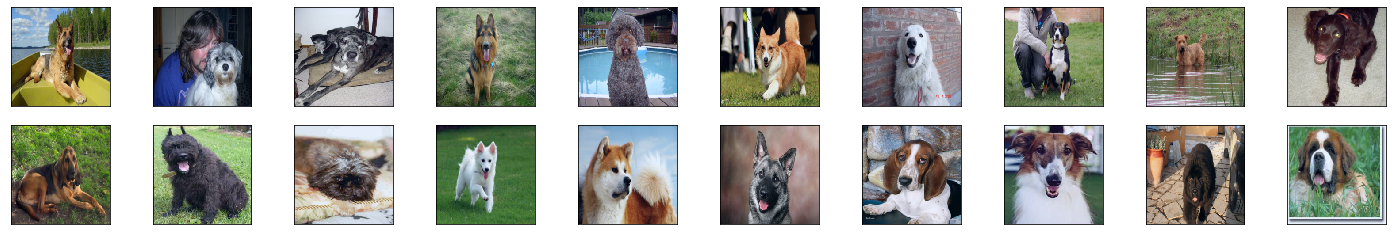

In [33]:
display_workload(loaders_scratch['test'])

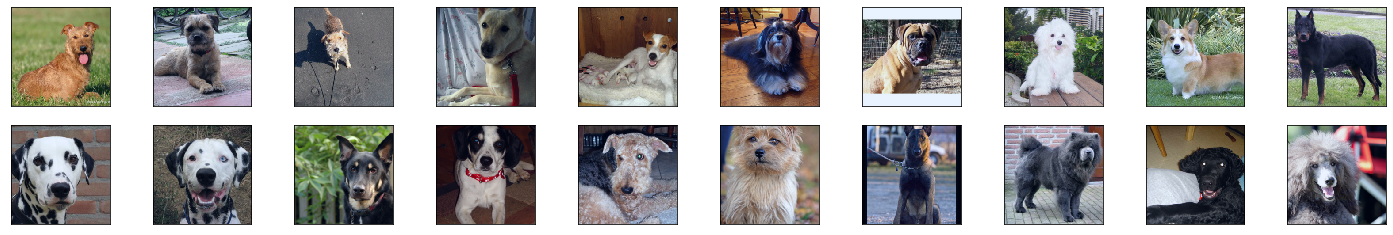

In [34]:
display_workload(loaders_scratch['valid'])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
1. How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
2. Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
<p style="color:#FF333D";><b>Reviewer comments 1</b>: How does your code resize the images (by cropping, stretching, etc)? What size did you pick for the input tensor, and why?</p>
<p style="color:#334DFF";> Images were randomly rotated, resized to 224 x 224 and used 3 channels, centered crop, and normalized. Images are relatively large, compared with MNIST images sizes. The reason for working with the proposed size, was to preseve, as many as possible, the original image properties and invariants. So that, during training these are generalized by the learning heuristic. Secondly, I also considered the amount of available resources, CPU and GPU memory buffer sizes, as a criterion for bounding the image size. I tested several image sizes. </p>
<p style="color:#FF333D";><b>Reviewer comments 1</b>: Did you decide to augment the dataset? If so, how (through translations, flips, rotations, etc)? If not, why not?</p>
<p style="color:#334DFF";>There are numerous augmentation techniques, i.e: geometric transformations, color space augmentations, kernel filters, mixing images, random erasing, feature space augmentation, adversarial training, generative adversarial networks, among others. See (Connor Shorten and Taghi M. Khoshgoftaar, 2019). Augmentation techniques are often applied as a pre-processing phase, were produced images are added to the original dataset. Kernel filters are commonly applied to blur or sharpen images. Convolutional neural networks include kernel filters in its encoding phase. Thus it automatically includes data augmentation. I did not apply data augmentation as a pre-processing phase.</p>

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [42]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        #define the convolutional layer
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        ## Define layers of a CNN
        self.fc1 = nn.Linear(64*28*28,1000)
        self.fc2 = nn.Linear(1000,1000)
        self.fc3 = nn.Linear(1000,500)
        self.fc4 = nn.Linear(500,133) 
        
        self.batch_norm2 = nn.BatchNorm1d(num_features=1000)
        self.batch_norm3 = nn.BatchNorm1d(num_features=500)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        x = F.relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.fc4(x)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if cuda_available:
    model_scratch.cuda()

In [43]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=133, bias=True)
  (batch_norm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__

<p style="color:#FF333D";><b>Reviewer comments 1</b>: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.</p>
<p style="color:#334DFF";>The CNN consists of three convolutional layers whose aim is to augment the data set by both reducing image noise and increasing the acutence of images. After each convolutional phase, negative values are removed via the relu activation function. Since the size and number of images resulting after a convolutional phase may be large, pooling is applied in order to reduce the amount of information and size of the image. Pooling may introduce information loss, but may be reduced by data augmentation. Finally, dropout is introduced in order to reduce overfitting. The depth, number of layers, in the reduction phase is bounded by the amount of information loss tolerable for the problem instance. In the proposed solution, images were shrunk significantly until there size reached 28x28.</p>
<p style="color:#334DFF";>The neural network layer, consists of four layers. Two dropout layers were added in order to reduce overfitting. Batch normalization is added in order to accelerate training and reduce covariance shift. Two phase of normalization was applied.</p> 
<p style="color:#334DFF";>The network was tested only a few times, but results were not promising. A test accuracy of 13% was achieved. The proposed feature extraction phase depth, which compromise the convolutional layers, is shallow when compared to VGG16 feature extraction phase. Perhaps, the performance of the proposed network might be improved by improving such phase.</p>

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [44]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [45]:
# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # record train ans validation lossess
    loss_batch = []
    loss_valid = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
        
        
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
        #record average losssess
        loss_batch.append(train_loss)
        loss_valid.append(valid_loss)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss 
    return loss_batch, valid_loss, model


# train the model
loss_batch, valid_loss, model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, cuda_available, 'model_scratch2.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch2.pt'))

Epoch: 1 	Training Loss: 4.983277 	Validation Loss: 126.376283
Validation loss decreased (inf --> 126.376283).  Saving model ...
Epoch: 2 	Training Loss: 4.807230 	Validation Loss: 4.897680
Validation loss decreased (126.376283 --> 4.897680).  Saving model ...
Epoch: 3 	Training Loss: 4.669751 	Validation Loss: 4.891207
Validation loss decreased (4.897680 --> 4.891207).  Saving model ...
Epoch: 4 	Training Loss: 4.511940 	Validation Loss: 4.522735
Validation loss decreased (4.891207 --> 4.522735).  Saving model ...
Epoch: 5 	Training Loss: 4.395568 	Validation Loss: 4.641390
Epoch: 6 	Training Loss: 4.297917 	Validation Loss: 4.675839
Epoch: 7 	Training Loss: 4.209301 	Validation Loss: 4.440095
Validation loss decreased (4.522735 --> 4.440095).  Saving model ...
Epoch: 8 	Training Loss: 4.105937 	Validation Loss: 4.399250
Validation loss decreased (4.440095 --> 4.399250).  Saving model ...
Epoch: 9 	Training Loss: 4.016523 	Validation Loss: 4.176144
Validation loss decreased (4.399250 

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [37]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [13]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, cuda_available)

Test Loss: 3.817867


Test Accuracy: 13% (116/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [46]:
## TODO: Specify data loaders
loaders_transfer = dict()
loaders_transfer['train'] = trainloader
loaders_transfer['test'] = testloader
loaders_transfer['valid'] = validloader

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [25]:
class classifier(nn.Module):
    def __init__(self, c_0_inputs):
        super().__init__()
        self.fc1 = nn.Linear(c_0_inputs, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500,133)
        
        self.batch_norm2 = nn.BatchNorm1d(num_features=1000)
        self.batch_norm3 = nn.BatchNorm1d(num_features=500)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.batch_norm2(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.fc4(x)

        return x

In [26]:
## TODO: Specify model architecture 
vgg16 = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
# I will replace all the classification layers.

c_0_inputs  = vgg16.classifier[0].in_features
vgg16.classifier = classifier(c_0_inputs)
    
print(vgg16.classifier)

if cuda_available:
    model_transfer = vgg16.cuda()

classifier(
  (fc1): Linear(in_features=25088, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=133, bias=True)
  (batch_norm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<p style="color:#FF333D";><b>Reviewer comments 1</b>: Outline the steps you took to get to your final CNN architecture and your reasoning at each step. Describe why you think the architecture is suitable for the current problem.</p>

<p style="color:#334DFF";>In this exercise, I kept vgg16 feature extraction phase and replaced the learning phase entirely by replacing it with the learning phase of the cnn that I created earlier. I did this, in order to test my hypothesis, that the feature extraction phase in the custom made cnn was not properly design. Features in the feature extraction phase were kept and in the learning phase were retrained. Results were very promising, test accuracy of 84% was achieved.</p>

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [39]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [25]:
# train the transfer model
loss_batch, valid_loss, model_transfer = train(100, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, cuda_available, 'model_scratch3.pt')


# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_scratch3.pt'))

Epoch: 1 	Training Loss: 4.597066 	Validation Loss: 4.071239
Validation loss decreased (inf --> 4.071239).  Saving model ...
Epoch: 2 	Training Loss: 3.832786 	Validation Loss: 3.294235
Validation loss decreased (4.071239 --> 3.294235).  Saving model ...
Epoch: 3 	Training Loss: 3.225330 	Validation Loss: 2.744397
Validation loss decreased (3.294235 --> 2.744397).  Saving model ...
Epoch: 4 	Training Loss: 2.743811 	Validation Loss: 2.333085
Validation loss decreased (2.744397 --> 2.333085).  Saving model ...
Epoch: 5 	Training Loss: 2.377515 	Validation Loss: 2.024208
Validation loss decreased (2.333085 --> 2.024208).  Saving model ...
Epoch: 6 	Training Loss: 2.087905 	Validation Loss: 1.792346
Validation loss decreased (2.024208 --> 1.792346).  Saving model ...
Epoch: 7 	Training Loss: 1.852640 	Validation Loss: 1.595844
Validation loss decreased (1.792346 --> 1.595844).  Saving model ...
Epoch: 8 	Training Loss: 1.657355 	Validation Loss: 1.470441
Validation loss decreased (1.59584

<All keys matched successfully>

<a name="TLRESULTS">
### (IMPLEMENTATION) Test the Model 
</a>

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [21]:
model_transfer.load_state_dict(torch.load('model_scratch3.pt'))

<All keys matched successfully>

In [13]:
test(loaders_transfer, model_transfer, criterion_transfer, cuda_available)

Test Loss: 0.501152


Test Accuracy: 84% (706/836)


<p style="color:#334DFF";><b> My comments 2</b>: After modifying the loaders, I directly applied the transfer-learned model (model_scratch3.pt), which previously achieved a precision of 84% to the new test set data loader. The new achieved accuracy is of <b>49%</b>. The code for this the new test is show in the following cell.</p>

In [38]:
model_transfer.load_state_dict(torch.load('model_scratch3.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, cuda_available)

Test Loss: 2.046817


Test Accuracy: 49% (411/836)


<p style="color:#334DFF";><b> My comments 2</b>: Results degradate by a factor of <b>1.7!</b>. It seems that image pre-processing phases corresponding to random horizontal flip, rotation, and center cropping significantly improved test accuracy. As described earlier, model scratch 3 was not retrained using a validation loader that omitted the previously  mention transformations. To analyze if the model quality improves, it is retrained and retested. See code in the following cells. </p>

In [47]:
# train the transfer model
loss_batch, valid_loss, model_transfer = train(100, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, cuda_available, 'model_scratch4.pt')

Epoch: 1 	Training Loss: 0.047734 	Validation Loss: 0.469103
Validation loss decreased (inf --> 0.469103).  Saving model ...
Epoch: 2 	Training Loss: 0.048244 	Validation Loss: 0.463061
Validation loss decreased (0.469103 --> 0.463061).  Saving model ...
Epoch: 3 	Training Loss: 0.047332 	Validation Loss: 0.467075
Epoch: 4 	Training Loss: 0.043777 	Validation Loss: 0.466281
Epoch: 5 	Training Loss: 0.044889 	Validation Loss: 0.468572
Epoch: 6 	Training Loss: 0.045816 	Validation Loss: 0.466513
Epoch: 7 	Training Loss: 0.042952 	Validation Loss: 0.474006
Epoch: 8 	Training Loss: 0.042780 	Validation Loss: 0.473524
Epoch: 9 	Training Loss: 0.041193 	Validation Loss: 0.463608
Epoch: 10 	Training Loss: 0.040998 	Validation Loss: 0.462575
Validation loss decreased (0.463061 --> 0.462575).  Saving model ...
Epoch: 11 	Training Loss: 0.041538 	Validation Loss: 0.471334
Epoch: 12 	Training Loss: 0.039427 	Validation Loss: 0.473825
Epoch: 13 	Training Loss: 0.040018 	Validation Loss: 0.468763
E

In [48]:
model_transfer.load_state_dict(torch.load('model_scratch4.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, cuda_available)

Test Loss: 0.566806


Test Accuracy: 84% (708/836)


<p style="color:#334DFF";><b> My comments 2</b>: After retraining the model, test accuracy was restore to 84%. It actually, improved slightly from a ratio of 706/836 to 708/836.</p>

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [213]:
# HELPER function. Gets the workload labels (unused, dont recomend this function)
def get_labels_from_loader(loader, name):
    items  = [items for (_, items) in enumerate(loader[name])]
    lists  = [item[1].tolist() for item in items]
    usval  = sorted(set(sum(lists,[]))) # unique sorted values indexed from 0 onward
    labels = [int(l) for l in usval]
    return labels

loader_class_labels = get_labels_from_loader(loaders_transfer, 'train')

In [22]:
def get_labels_from_filesystem(img_working_dir):
    dictionary = dict()
    files = os.listdir(img_working_dir)
    for file in files:
        key, val = file.split('.')
        dictionary[int(key)] = val
    return dictionary

class_labels = get_labels_from_filesystem(os.getcwd() + "\\dogImages\\test")

In [24]:
# HELPER function: given a file path, display the image
def display_img(img_path, name):
    params = {"text.color" : "blue"}
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(name, pad=10)
    plt.show()
    plt.rcParams.update(params)

In [324]:
def show_predictions(model, loader, train_on_gpu, labels):
    # obtain one batch of test images
    dataiter = iter(loader)
    images, _ = dataiter.next() # at a later time analyze labels
    images.numpy()
    imgs = images

    # move model inputs to cuda, if GPU available
    #if train_on_gpu:
   #     images = images.cuda()
    if cuda_available:
        images = images.cuda()
        model = model.cuda()


    # get sample outputs
    output = model(images)

    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    
    if train_on_gpu:
        preds = np.squeeze(preds_tensor.cpu().numpy())
    else:
        preds = np.squeeze(preds_tensor.numpy())

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        img = imgs[idx]
        img = (img-torch.min(img))/(torch.max(img)-torch.min(img)) #apply min-max normalization
        plt.imshow(np.transpose(img, (1, 2, 0)))
        k = preds[idx]+1
        ax.set_title("{}".format(labels[k]))
        #ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
        #         color=("green" if preds[idx]==labels[idx].item() else "red"))

In [20]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
def  Dog_breed_detector(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    # load and prepare the model  
    model = models.vgg16(pretrained=True)
    
    # Freeze training for all "features" layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    c_0_inputs  = model.classifier[0].in_features
    model.classifier = classifier(c_0_inputs)
    
    model.load_state_dict(torch.load('model_scratch3.pt'))
    if cuda_available:
        model = model.cuda()
    model.eval()
    
    
    img = Image.open(img_path)
    
    # define image transformations
    transformations = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])
   
    # apply the image transformations
    img = transformations(img).unsqueeze_(0)
    
    # map to gpu
    if cuda_available:
        img   = img.cuda()
        
    output = model(img)
    
    _, pred = torch.max(output, 1)

    pred = np.squeeze(pred.numpy()) if not cuda_available else np.squeeze(pred.cpu().numpy())
    return int(pred) + 1

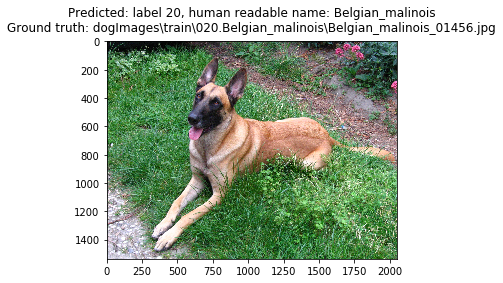

In [25]:
# Test code for transfer_predict. I did not use the class_labels, but the inverse table labels retreived with a 
img_path  = dog_files[2000]
cid       = Dog_breed_detector(img_path) # previously named transfer_predict
labels    = get_labels_from_filesystem(os.getcwd()+ "\\dogImages\\test")
name      = "Predicted: label " + str(cid) + ", human readable name: " + labels[cid] + "\n" + "Ground truth: " + img_path
display_img(img_path, name)

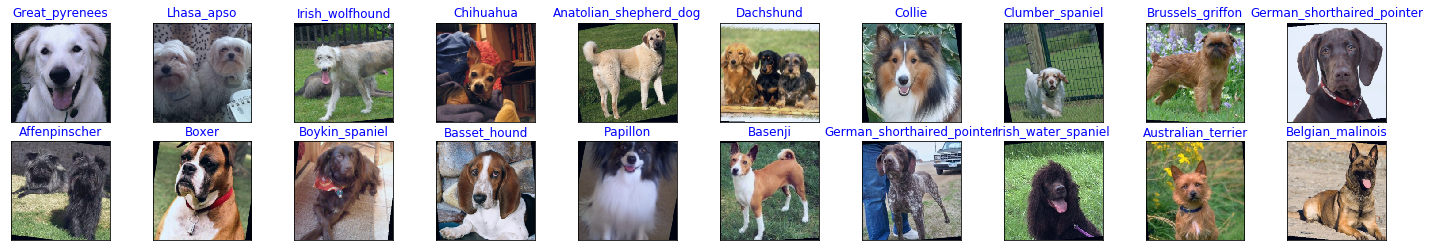

In [326]:
# Finally show multiple predictions at once
show_predictions(model_transfer, loaders_transfer['test'], cuda_available, labels)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## load the necessary models.
    if( VGG16_dog_detector(img_path) ):     # a dog is detected
        return Dog_breed_detector(img_path) # return its breed
    if( Haar_detector(img_path) ):          # a human is detected
        return Dog_breed_detector(img_path) # return a breed with highest similarity
    return -1                               # error

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

<p style="color:#FF333D";><b>Reviewer comments 1</b>: Is the output better than you expected :) ? Or worse :( ? Provide at least three possible points of improvement for your algorithm.</p>

<p style="color:#334DFF";>The new dog detector works fine. As described earlier, it achieves a test accuracy of 84%. It can be improved further by exploring other normalization, data augmentation, or other techniques. Finding the resemblance between a human and a dog is complicated, as geometric and texture characteristics between dogs and humans are quite different. Human - dog similarity might be improved by encoding the dog image set and the given human image, later by using an unsupervised method, such as KNN or T-SNE, to determine to which image set the human picture relates to.</p>

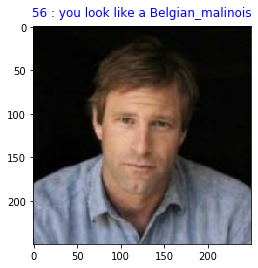

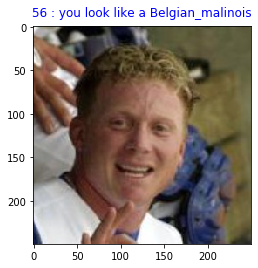

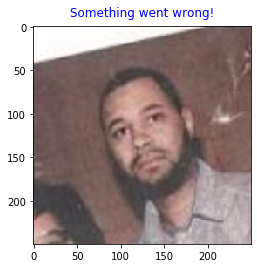

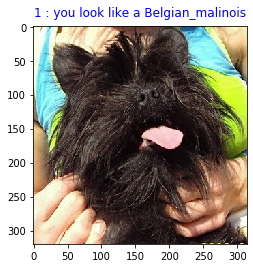

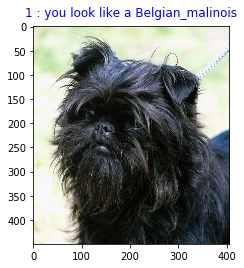

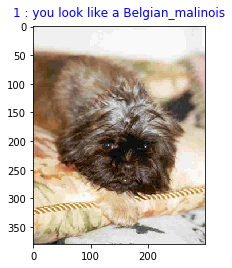

In [37]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

labels    = get_labels_from_filesystem(os.getcwd()+ "\\dogImages\\test")

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    oid = run_app(file)
    if oid != -1:
        label = str(oid) + " : you look like a " + labels[cid]
    else:
        label = "Something went wrong!"
    display_img(file, label)
    